# 问题情境

离群值：一个观测值与其它观测值偏离太多而引起猜疑，认为它产生于不同的机制
离群值又称为异常值、野值

异常对象被称作离群点。异常检测也称偏差检测和例外挖掘。

    常见的异常成因：数据来源于不同的类（异常对象来自于一个与大多数数据对象源（类）不同的源（类）的思想），自然变异，以及数据测量或收集误差。

    异常检测的方法：

（1）基于模型的技术：首先建立一个数据模型，异常是那些同模型不能完美拟合的对象；如果模型是簇的集合，则异常是不显著属于任何簇的对象；在使用回归模型时，异常是相对远离预测值的对象。

（2）基于邻近度的技术：通常可以在对象之间定义邻近性度量，异常对象是那些远离其他对象的对象。

（3）基于密度的技术：仅当一个点的局部密度显著低于它的大部分近邻时才将其分类为离群点。


# 准备工作

加载数据挖掘必备的几个模块：

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling
#w文件路径操作
import os
#绘图
from plotnine import *
%matplotlib inline

In [3]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

忽略掉一些警告，保持界面整洁：

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
rng = np.random.RandomState(2012)

# 数据导入

In [6]:
data_folder = os.path.join("datasets", "lon_lat")
org_lon_lat_filename = os.path.join(data_folder, "lon_lat.xls")
org_lon_lat_filename

'datasets\\lon_lat\\lon_lat.xls'

In [7]:
org_lon_lat = pd.read_excel(org_lon_lat_filename)

In [8]:
org_lon_lat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17362 entries, 0 to 17361
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         17362 non-null  int64  
 1   LATITUDE   13487 non-null  float64
 2   LONGITUDE  13487 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 407.0 KB


In [9]:
org_lon_lat.describe()

,id,LATITUDE,LONGITUDE
count,17362.000000,13487.000000,13487.000000
mean,110040.271685,36.208740,105.839463
std,41191.617100,11.233293,32.835076
min,229.000000,0.000000,0.000000
25%,87696.750000,39.620263,115.925941
50%,111316.500000,39.703984,116.036366
75%,146456.500000,39.737676,116.132254
max,155953.000000,40.095809,116.929495


In [10]:
org_lon_lat_report = pandas_profiling.ProfileReport(org_lon_lat)
org_lon_lat_report.to_file('D://desktop/org_lon_lat_report.html')

In [11]:
org_lon_lat.head()

,id,LATITUDE,LONGITUDE
0,229,39.607838,116.004209
1,237,39.667061,115.999070
2,251,39.626235,115.993207
3,252,39.662049,115.986380
4,253,39.667218,115.992402


In [12]:
print(org_lon_lat.shape)

(17362, 3)


In [13]:
org_lon_lat.columns

Index(['id', 'LATITUDE', 'LONGITUDE'], dtype='object')

重命名，并调整一下列的顺序：

In [14]:
org_lon_lat.columns = ['org_id', 'lat', 'lon']
org_lon_lat = org_lon_lat[['org_id', 'lon', 'lat']]

查看缺失值情况：

In [15]:
org_lon_lat.isnull().sum() / org_lon_lat.shape[0]

org_id    0.000000
lon       0.223189
lat       0.223189
dtype: float64

我们只是采用其中的经纬度，为了后续方便，作如下处理：

In [16]:
lon_lat = org_lon_lat.drop('org_id', axis=1).dropna()
lon_lat

,lon,lat
0,116.004209,39.607838
1,115.999070,39.667061
2,115.993207,39.626235
3,115.986380,39.662049
4,115.992402,39.667218
...,...,...
17357,116.184948,39.781959
17358,115.599129,39.648606
17359,115.598909,39.647612
17360,115.966009,39.728562


查看字段的类型：

In [17]:
lon_lat.dtypes

lon    float64
lat    float64
dtype: object

# 探索性数据分析

## 用少量数字描述数据

In [18]:
lon_lat.describe()

,lon,lat
count,13487.000000,13487.000000
mean,105.839463,36.208740
std,32.835076,11.233293
min,0.000000,0.000000
25%,115.925941,39.620263
50%,116.036366,39.703984
75%,116.132254,39.737676
max,116.929495,40.095809


显然，这里边经纬的的最小值为0，这明显属于脏数据，直接剔除——当然，假如从异常数据的角度来看，它们也是异常得离谱：

In [19]:
lon_lat.shape

(13487, 2)

In [20]:
lon_lat = lon_lat[(lon_lat.lon != 0) & (lon_lat.lat != 0)]
lon_lat.shape

(12303, 2)

## 散点图

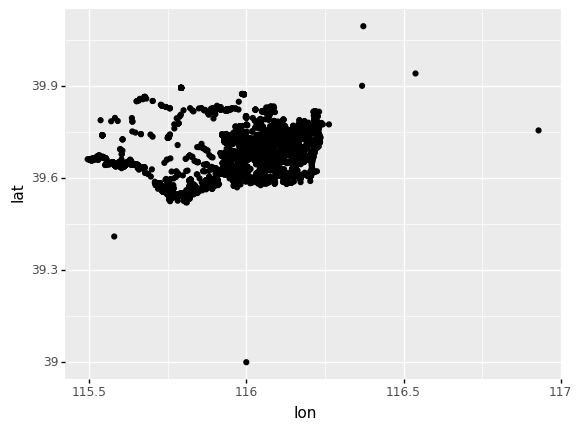

<ggplot: (78073913414)>

In [21]:
(
    ggplot(lon_lat, aes(x='lon', y='lat')) +
    geom_point()
)

看不出什么规律，但是加上一个参数alpha=0.1之后就不一样了：

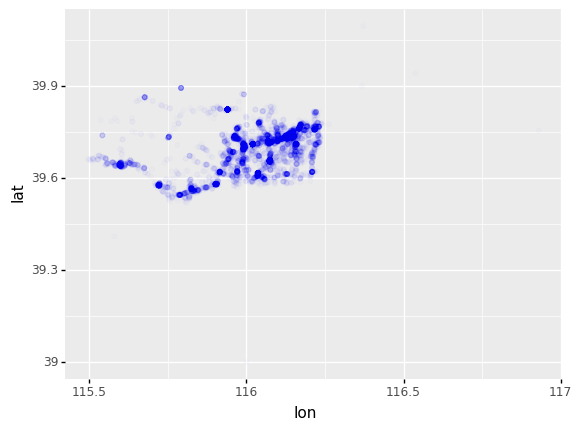

<ggplot: (78074105778)>

In [22]:
(
    ggplot(lon_lat, aes(x='lon', y='lat')) +
    geom_point(alpha=0.01, colour='blue')
)

## 经纬度分布

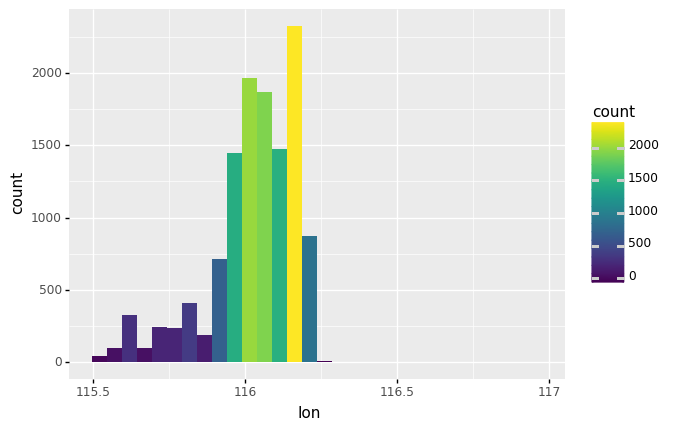

<ggplot: (78074105820)>

In [23]:
(
    ggplot(lon_lat, aes(x='lon', fill='stat(count)')) +
    geom_histogram(bins=30)
)

In [24]:
lon_lat_melt = lon_lat.melt(value_vars=['lon', 'lat'],
                           var_name='type',
                           value_name='value')
lon_lat_melt

,type,value
0,lon,116.004209
1,lon,115.999070
2,lon,115.993207
3,lon,115.986380
4,lon,115.992402
...,...,...
24601,lat,39.781959
24602,lat,39.648606
24603,lat,39.647612
24604,lat,39.728562


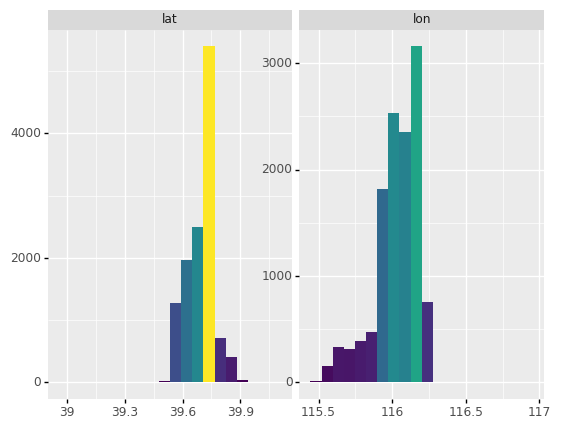

<ggplot: (78073946874)>

In [25]:
(
    ggplot(lon_lat_melt, aes(x='value', fill='..count..')) +
    geom_histogram(bins=20) +
    facet_wrap('type', nrow=1, scales='free') +
    theme(legend_position='none') +
    labs(x=None, y=None)
)

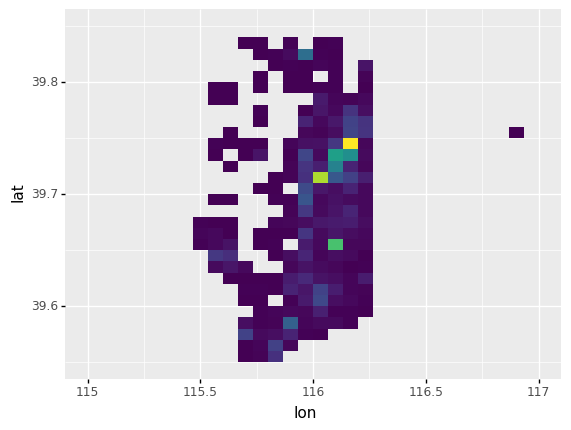

<ggplot: (78072733856)>

In [26]:
(
    ggplot(lon_lat, aes(x='lon', y='lat')) +
    geom_bin2d(bins=30) +
    xlim(115, 117) +
    ylim(39.55, 39.85) +
    theme(legend_position='none')
)

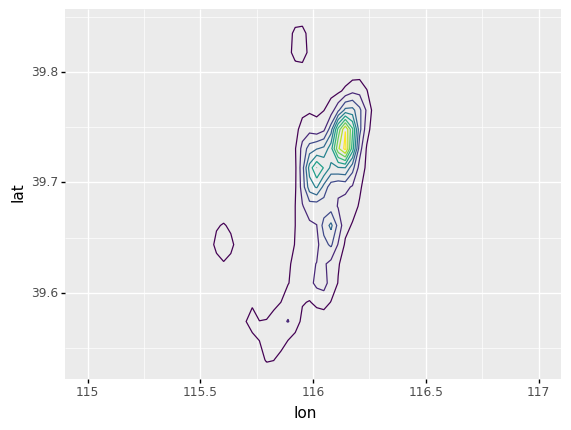

<ggplot: (78073881155)>

In [27]:
(
    ggplot(lon_lat, aes(x='lon', y='lat')) +
    geom_density_2d(aes(colour='..level..'), levels=10) +
    xlim(115, 117) +
    #ylim() +
    theme(legend_position='none')
)

## 算法建模

In [28]:
import matplotlib.pyplot as plt

### 部分参数设置

In [29]:
X = lon_lat.values
n_samples = X.shape[0]
n_features = X.shape[1]
outliers_fraction = 0.01
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [30]:
lon_min, lon_max = lon_lat.lon.min(), lon_lat.lon.max() 
lat_min, lat_max = lon_lat.lat.min(), lon_lat.lat.max() 
resolution = 150

In [31]:
colors = np.array(['red', 'green'])
alpha=0.25

### 箱线图规则Boxplot Rule

该方法可视为箱图规则的一个变形，因为二者都采用离中心值的距离来决定一个值的“离群程度”。计算方法如下：

$o{s_i} = \frac{{\left| {{x_i} - median\left( x \right)} \right|}}{{IQR\left( x \right)}}$

In [32]:
class BoxplotOutlier():
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X_train, y=None):
        self.center = np.median(X_train, axis=0)
        self.scale = np.percentile(X_train, [75], axis=0) - np.percentile(X_train, [25], axis=0)
        self.boxplot_score_train = np.abs((X_train - self.center) / self.scale).sum(axis=1)
        self.offset_ = np.percentile(-self.boxplot_score_train, 100. * self.contamination)
        return self

    def decision_function(self, X_test, raw_values=None):
        negative_boxplot_score = self.score_samples(X_test)
        return negative_boxplot_score - self.offset_

    #计算总体离群系数，显然，由于进行了IQR的缩放，二者直接相加即可
    def score_samples(self, X_test):
        self.boxplot_score = np.abs((X_test - self.center) / self.scale).sum(axis=1)
        return -self.boxplot_score

    def predict(self, X_test):
        is_inlier = np.full(X_test.shape[0], -1, dtype=int)
        values = self.decision_function(X_test)
        is_inlier[values >= 0] = 1
        return is_inlier

In [33]:
clf = BoxplotOutlier(contamination=outliers_fraction)
clf.fit(X)

In [34]:
def plot_outliers(X, clf, alpha=alpha):
    if isinstance(clf, LocalOutlierFactor):
        X_scores=clf._decision_function(X)
        y_pred = clf.fit_predict(X)
    else:
        X_scores=clf.decision_function(X)
        y_pred = clf.predict(X)
    # 绘制原始点
    plt.scatter(X[:, 0],
                X[:, 1],
                color=colors[(y_pred + 1) // 2],
                s=40,
                edgecolor='white',
                alpha=alpha)
    # 圈出异常点
    radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
    threshold = np.percentile(radius, (1 - outliers_fraction) * 100)
    radius = np.where(radius >= threshold, radius, 0)
    plt.scatter(X[:, 0], X[:, 1],
                s=1000 * radius,
                edgecolors='r',
                facecolors='none')

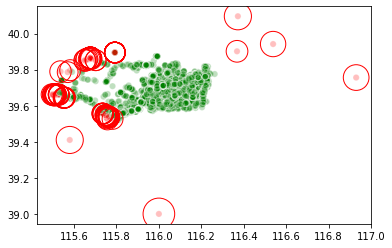

In [35]:
plot_outliers(X, clf)

我们也可以进一步看看离群系数在整个空间里的分布情况：

In [36]:
def plot_outlier_with_contour(X, clf, title, resolution=150, alpha=0.25):
    X0_min, X0_max = X[:, 0].min(), X[:, 0].max() 
    X1_min, X1_max = X[:, 1].min(), X[:, 1].max() 
    # plot the level sets of the decision function 
    xx, yy = np.meshgrid(np.linspace(X0_min, X0_max, resolution), 
                     np.linspace(X1_min, X1_max, resolution))
    if isinstance(clf, LocalOutlierFactor):
        X_scores=clf._decision_function(X)
        y_pred = clf.fit_predict(X)
        Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        X_scores=clf.decision_function(X)
        y_pred = clf.predict(X)
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape)  
    
    plt.title(title)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r) 
    
    plot_outliers(X,clf, alpha)

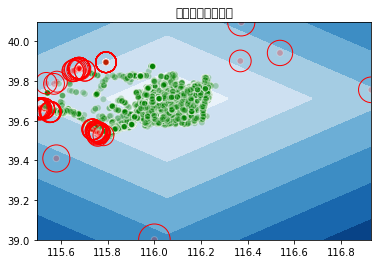

In [37]:
plot_outlier_with_contour(X, clf, title="修正的箱线图规则")

### 局部离群因子Local Outlier Factor

https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py

<img src=figtabs/ch7/lof.png align=left width=63% />

局部离群值因子（LocalOutlier Factor, LOF)方法被认为是最经典的离群值排序法之一。这个方法的主要思想是试着通过估计样本和它的局部邻域的分离程度来得到该样本的离群值分数。<br>
* 根据给定的最少邻居数$k$和最近邻距离来确定邻域
* 通过计算数据点的$k$近邻距离、可达距离和可达密度,用数据点邻域的平均可达密度和数据点自身的可达密度之比表示$LOF$
* 若点$p$的密度与其邻域内其它点的密度相差很大($LOF$值较大),则点$p$被判定为局部孤立点

为了更好地理解上述思想，我们先给出一些概念定义：

<font color='green'>**第1个概念**</font>：<br>
对象$p$的第$k$距离$k - distance\left( o \right)$：<br>
存在对象$o$，它与对象$p$之间的距离记为$d\left( {p,o} \right)$<br>
如果满足以下两个条件，我们则认为$k - distance(p) = d(p,o)$：<br>
1. 至少存在$k$个点，使得$d(p,q) \le d(p,o)$<br>
2. 最多有不包含$p$在内的$k-1$个点，使得$d(p,q) < d(p,o)$<br>

显然，满足这两个标准的$k - distance\left( o \right)$，其实就是计算样本空间中其他对象与对象$p$之间的距离，然后找到第$k$大的那个距离。对象密度较大的距离，$k - distance\left( o \right)$值相对较小；而对象密度较小的区域，$k - distance\left( o \right)$值相对较大

---

<font color='green'>**第2个概念**</font>：<br>
点$o$至$p$的可达距离$Reach - dist\left( {p,o} \right)$<br>
点$o$至$p$的可达距离是$k - distance\left( o \right)$与$d\left( {p,o} \right)$中较大的那个，即：$Reach - dist\left( {p,o} \right) = \max \left\{ {k - distance\left( o \right),d\left( {p,o} \right)} \right\}$<br>

换言之，点$o$到点$p$的第$k$可达距离，至少是$o$的第$k$距离，或者为$o$、$p$间的真实距离

---

<font color='green'>**第3个概念**</font>：<br>
点$p$的局部可达密度$lr{d_k}(p)$<br>
点$p$的局部可达密度是$p$的$k$最近邻点的平均可达距离的倒数：$lr{d_k}(p) = \frac{{\left| {{N_{kdis(p)}}(p)} \right|}}{{\sum\nolimits_{o \in {N_{kdis(p)}}(p)} {Reachdi{s_k}(p,o)} }}$<br>

局部可达密度和可达距离的理解：如果$p$和周围邻域点是同一簇，那么可达距离越可能为$o$的第$k$距离，可达距离之和较小，密度值较高，而且大家都差不多；如果$p$和周围邻居点较远，那么可达距离可能都会取较大值$d(p,o)$，导致密度较小，越可能是离群点。 

---

<font color='green'>**第4个概念**</font>：<br>
也就是我们的局部离群点因子$LO{F_k}\left( p \right)$<br>
局部离群点因子被定义为用数据点邻域的平均可达密度和数据点自身的可达密度之比：$LO{F_k}\left( p \right) = \frac{{\frac{1}{{\left| {{N_k}\left( p \right)} \right|}}\left( {\sum\nolimits_{o \in {N_k}\left( p \right)} {lrd\left( o \right)} } \right)}}{{lrd\left( p \right)}}$<br>

如果对象 $p$ 的离群程度较大，则它$k$邻域中大多数是离对象$p$较远且处于某一个类簇的数据点，那么这些数据点的$lrd$应该偏大，而对象$p$的$lrd$是偏小的，最后所得到的LOF值也是偏大的；反之，如果对象$p$的离群程度较小，对象$o$的$lrd$和对象$p$的 $lrd$相似，最后所得到的$LOF$应该接近于1

上述概念的理解，只是直观上的，关于更多的理论细节，可参照LOF原文：<br>
> Breunig, M. M., Kriegel, H. P., Ng, R. T., & Sander, J. (2000, May). LOF: identifying density-based local outliers. In ACM sigmod record.

首先加载相关的包：

In [38]:
from sklearn.neighbors import LocalOutlierFactor

In [39]:
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=30,
                        contamination=outliers_fraction)
clf.fit(X)

LocalOutlierFactor(contamination=0.01, n_neighbors=30)

In [40]:
X_scores = clf._decision_function(X)

In [41]:
y_pred = clf.fit_predict(X)

看看数据的离群程度，当然我们也可以称之为异常系数，通过negative_outlier_factor_获得。从negative_outlier_factor_名字上就可以看出来，他是异常系数的相反值，越高越正常。在后续绘图代码中的处理。

In [42]:
X_scores2 = clf.negative_outlier_factor_

In [43]:
X_scores - X_scores2

array([13.68065449, 13.71349253, 13.67871452, ..., 13.68255204,
       13.69311592, 13.68816981])

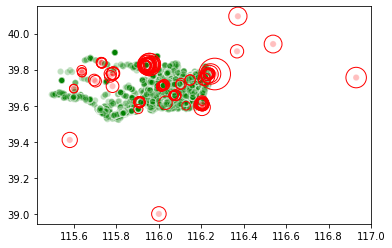

In [44]:
plot_outliers(X, clf)

同样，我们来看看离群因子的边界：

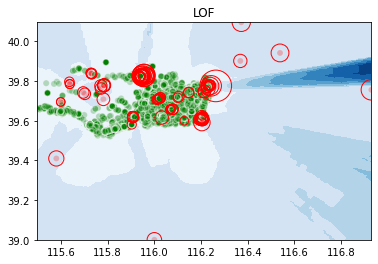

In [45]:
plot_outlier_with_contour(X, clf, title="LOF")

### 单类支持向量机One-class SVM

基本思想：<br>
>通过在映射到高维的特征空间中找出一个包围目标样本点的超球体，并通过最小化该超球体所包围的体积让目标样本点尽可能地被包围在超球体中，而非目标样本点尽可能地排除在超球体中，从而达到两类之间划分的目的。

<img src=figtabs/ch7/one_class_svm.png align=left width=63%/>

对于正常数据样本$\left\{ {x|{x_i} \in {R^d},i = 1,2, \cdots ,N} \right\}$，在映射的高维空间内，求出能够包含该数据样本的最小超球体的中心$a$和半径$R$，问题转化为求以下优化问题：<br>
$\begin{array}{l}
\min {R^2} + C\sum\limits_{i = 1}^N {{\xi _i}} \\
s.t.{\left\| {\phi \left( x \right) - a} \right\|^2} \le {R^2} + {\xi _i}
\end{array}$ <br>
在模型中，${{\xi _i}}$为松弛因子，当${\xi _i} > 0$对应位于超球体外部的非目标类数据点。求得该超球体后，得判别函数：<br>
$f\left( x \right) = {\mathop{\rm sgn}} \left( {{R^2} - {{\left\| {\phi \left( x \right) - a} \right\|}^2}} \right)$<br>
通过解凸二次优化可得球心a和半径R，求解所得大部分拉格朗日乘子的系数为零，而对应${\alpha _i} > 0$的向量则为支持向量，超球体的半径为任何一边界支持向量到球心的距离：<br>
$\left\{ {\begin{array}{*{20}{c}}
{a = \sum\limits_{i = 1}^{{N_{sv}}} {{\alpha _i}K\left( {{x_i},{x_i}} \right)} }\\
{{R^2} = K\left( {{x_m},{x_m}} \right) - 2\sum\limits_{i = 1}^{{N_{sv}}} {{\alpha _i}K\left( {{x_i},{x_m}} \right)}  + \sum\limits_{i = 1}^{{N_{sv}}} {\sum\limits_{j = 1}^{{N_{sv}}} {{\alpha _i}{\alpha _j}K\left( {{x_i},{x_j}} \right)} } }
\end{array}} \right.$

In [46]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X)

OneClassSVM(gamma=0.1, nu=0.1)

In [47]:
X_scores = clf.decision_function(X)

In [48]:
y_pred = clf.predict(X)

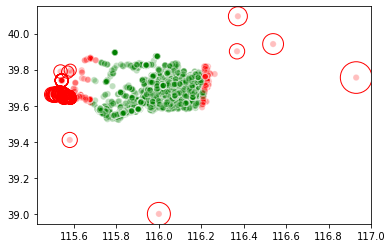

In [49]:
plot_outliers(X, clf)

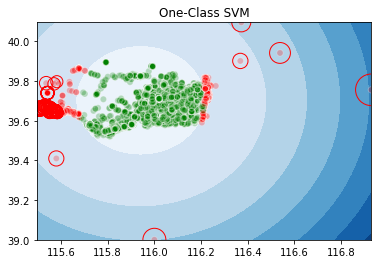

In [50]:
plot_outlier_with_contour(X, clf, title="One-Class SVM")

### 孤立森林IsolationForest

孤立森林算法的基本过程是对数据集进行子采样并构造iTree，然后将多个iTree集成为iForest检测异常数据：<br>
1. 从训练数据集中随机选择$\Psi $个样本数据点作为子采样集，并构造一棵初始iTree，将子采样集放入树的根节点
2. 随机指定数据项的一个属性维度$q$，在当前节点数据中随机产生一个切割点$p$（切割点产生于当前节点中数据q属性的最大值与最小值之间）
3. 以此切割点生成一个超平面，将当前节点的数据空间划分为两个子空间。把指定$q$属性的值小于p的数据项放入当前树节点的左子空间中；反之，放入右子空间中
4. 递归执行步骤2和步骤3，不断构造新的子空间节点，直到子空间节点中只有一个数据项（无法继续切割）或该iTree已经达到初始定义好的限定高度

看看原始文献对这一过程的算法描述：

<img src=figtabs/ch7/iForest2.png align=left width=63% />

以上便完成了iTree的训练。接下来看看如何构造iForest：<br>
iForest和Random Forest的方法有些类似，都是随机采样一部分数据集去构造每一棵树，保证不同树之间的差异性。不过iForest与RF不同，给定一个包含$n$条记录的数据集$D$，采样的数据量不需要等于$n$，可以远远小于$n$（采样大小超过256效果就提升不大了，并且越大还会造成计算时间的上的浪费）。<br>
除了限制采样大小$\Psi $以外，还要给每棵iTree设置最大高度$l = ceiling\left( {{{\log }_2}\Psi } \right)$，因为异常数据记录都比较少，其路径长度也比较低，而我们也只需要把正常记录和异常记录区分开来，只需要关心低于平均高度的部分就好，这样算法效率更高，后面可以看到计算$h(x)$需要一点点改进。以下是原始文献中对于iForest的具体构建过程：

<img src=figtabs/ch7/iForest1.png align=left width=63% />

接下来可以定义孤立森林算法对异常数据的评价体系，对于测试数据$x$，将其代入森林中的每一棵iTree，计算其落在每棵树的深度，记为$h(x)$，所有$h(x)$的平均值为$E(h(x))$，因为iTree的结构和二叉搜索树相似，所以设置标准平均搜索长度${c\left( \Psi  \right)}$为：<br>
$\begin{array}{l}
c\left( \Psi  \right) = 2H\left( {\Psi  - 1} \right) - \left[ {2\left( {\Psi  - 1} \right)/\Psi } \right]\\
H\left( i \right) = \ln \left( i \right) + 0.5772
\end{array}$<br>
可定义一个待测数据的异常评分为：<br>
$s\left( \Psi  \right) = {2^{ - \frac{{E\left( {h\left( x \right)} \right)}}{{c\left( \Psi  \right)}}}}$

当$s\left( \Psi  \right)$接近1，即在iTree分支的深度最小时，该数据是异常数据；当$s\left( \Psi  \right)$接近零，即在iTree分支的深度最大时，是正常数据。从直觉上看：发现那些密度很高的簇是可以被切很多次才会停止切割，但是那些密度很低的点很容易很早的就停到一个子空间了。

In [51]:
from sklearn.ensemble import IsolationForest

In [52]:
# fit the model
clf = IsolationForest(behaviour='new', 
                      max_samples=100,
                      random_state=rng, 
                      contamination=outliers_fraction)
clf.fit(X)

IsolationForest(behaviour='new', contamination=0.01, max_samples=100,
                random_state=RandomState(MT19937) at 0x122D4D5B540)

In [53]:
X_scores = clf.decision_function(X)

In [54]:
y_pred = clf.predict(X)

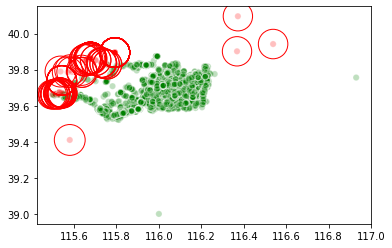

In [55]:
plot_outliers(X, clf)

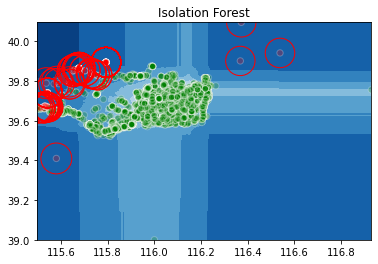

In [56]:
plot_outlier_with_contour(X, clf, title="Isolation Forest")

### 与实际地图数据的比较

地图显示用到了Basemap，安装方法稍微复杂一点：<br>
* 在<http://www.lfd.uci.edu/~gohlke/pythonlibs/>网站下载pyproj安装包 (whl格式，116M)
* 在<http://www.lfd.uci.edu/~gohlke/pythonlibs/>网站下载basemap安装包 (whl格式，3M)

将这两个文件放在某个文件夹，然后在cmd中cd至该文件夹，并执行以下命令：<br>
* pip install pyproj-1.9.6-cp37-cp37m-win_amd64.whl
* pip install basemap-1.2.0-cp37-cp37m-win_amd64.whl

先安装pyproj，否则basemap可能无法安装

具体的地图数据需要自行收集，如果自己已经收集的shape file当然是最好。当然也可以直接从一些公开渠道下载，比如gdam:<https://gadm.org/download_country_v3.html><br>
下载好地图数据，解压缩至datasets/chn_map文件夹下，接着可以执行以下代码：

In [57]:
lon_min, lon_max = lon_lat.lon.min(), lon_lat.lon.max() 
lat_min, lat_max = lon_lat.lat.min(), lon_lat.lat.max() 
lon_center = (lon_min+lon_max)/2
lat_center=(lat_min+ lat_max)/2

In [58]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(10,8))
mm = Basemap(llcrnrlon=lon_min,
             llcrnrlat=lat_min,
             urcrnrlon=lon_max,
             urcrnrlat=lat_max,
             resolution='i',
             projection='tmerc',
             lat_0=lat_center, lon_0=lon_center)
mm.readshapefile('datasets/chn_map/gadm36_CHN_3',
                 'counties', drawbounds=True)
#增加经线和纬线
parallels = np.linspace(lat_min, lat_max, 5)
mm.drawparallels(parallels, labels=[False, True, True, False])
meridians = np.linspace(lon_min, lon_max, 5)
mm.drawmeridians(meridians, labels=[False, True, True, False])

#原始的lon、lat进行转换
x, y = mm(X[:, 0], X[:, 1])
#绘制散点图
mm.scatter(x, y,
           color=colors[(y_pred + 1) // 2],
           s=40,
           edgecolor='white',
           alpha=alpha)
# 圈出异常点
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
threshold = np.percentile(radius, (1 - outliers_fraction) * 100)
radius = np.where(radius >= threshold, radius, 0)
mm.scatter(x, y,
           s=1000 * radius,
           edgecolors='r',
           facecolors='none')

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'